<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Thoughts" data-toc-modified-id="Thoughts-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Thoughts</a></span><ul class="toc-item"><li><span><a href="#Augmentation" data-toc-modified-id="Augmentation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Augmentation</a></span></li></ul></li><li><span><a href="#Download-Data" data-toc-modified-id="Download-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Download Data</a></span></li><li><span><a href="#Scene-Data" data-toc-modified-id="Scene-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scene Data</a></span><ul class="toc-item"><li><span><a href="#Superpixels" data-toc-modified-id="Superpixels-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Superpixels</a></span></li></ul></li><li><span><a href="#VQATools-Demo" data-toc-modified-id="VQATools-Demo-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>VQATools Demo</a></span></li><li><span><a href="#Demo-Model" data-toc-modified-id="Demo-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Demo Model</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle

import sys
sys.path.append('VQA/PythonHelperTools/vqaTools/')
from vqa import VQA

from tf_layers.tf_utils import tf_init

config = tf_init()

%matplotlib inline

/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# Thoughts
A vector for each object + a vector for the scene
* composed of the information we already have (object name, x, y, etc.) + image information
    * What should that part look like? Consider having a base CNN, then train one additional conv layer for each object type (+ one for the global scene). The output of that layer is flattened and used for the vector.
    * Does it make sense that each object type would have its own conv layer? Or what's another way that we could have each object get potentially different information about the scene that corresponds to relationships about that particular object?

---

* Want more than just (x,y) for each object; a bounding box/polygon would be nicer. For relations between objects, what else do we need / can we encode?
    * To get bounding boxes (or at least some approximation thereof) maybe try doing some segmentation method? (or superpixels). Then for each object, take whatever region has its (x, y) coord as the segment for that object and make the box around it
* Look at the data more and think about what you, as a human, need in order to answer these questions
    * If you just had a set of boxes for the main objects in the image, could you do it? What additional information would the boxes need to have? (e.g. color)
    * For the more global data (e.g. is this a wintry scene?), could we just run a pre-trained model from Places on the images and use the output from that as additional input?
* How to go from a (variable-sized) graph to a fixed size? Or can you keep it variable by using an RNN over it?
    * Read more about NNs on graphs
    * Fully-connected graph to explicitly represent the connections between all objects; is there any more data you can put on the edges except relative position of the objects? How to encode relative position? dx, dy of the center point or a given corner? dx, dy between all pairs of corners (so, if you have a box for each object, 16 pairs of corners)
* Once we know what objects there are, we can probably do a great deal with textual information. Image data will always be necessary to perform at human level, but how much will low-hanging fruit help? Consider "Is there any healthy food?". For each object, we need to know if it's food and if it's healthy. Maybe store with an object words which are commonly used together with that object? (as, e.g., word embeddings)

---

* Embed the words in a learned embedding; use an LSTM that takes as input at each timestep the result of convolving the current word embedding with the image vector

## Augmentation
* you can make many more questions if you know about the objects in the images. You can ask "Is there an <object>?", "How many <objects> are there?", "What color is the <object>?", "What is to the left of the <object>?"
    * How well do the sort of questions you could generate automatically match with the real questions?
* What kinds of image augmentation will be good / bad?
    * E.g. if a question asks about left/right, doing an LR flip would be bad

# Download Data
Download links for the VQA dataset are from [here][links]. The GloVe vectors are from [here][glove]; these ones are trained on Wikipedia; they also have a couple of other sets available for download (these are the ones with the smallest vocabulary).

For the VQA tools, you'll need to run `2to3` on any(?) `.py` files that you need to use. If there are space/tab issues, one quick fix is to use `:retab` in `vim`. 

[links]: http://visualqa.org/download.html
[glove]: https://github.com/stanfordnlp/GloVe

In [14]:
%%bash

# get the vqa helper tools to assist with loading the data
if [[ ! -e VQA ]]; then
    echo "Downloading VQA tools"
    git clone https://github.com/VT-vision-lab/VQA.git
fi

mkdir -p data
cd data

# word embeddings
if [[ ! -e glove ]]; then
    echo "Downloading GloVe embeddings"
    mkdir glove
    cd glove
    wget -q http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
    unzip -qq "*.zip"
    rm *.zip
fi

# vqa dataset; getting the images will take some time
# read more on the download page: http://www.visualqa.org/vqa_v1_download.html

# v1: abstract scenes
for split in train val; do
    if [[ ! -e $split ]]; then
        echo "Downloading $split annotations and questions"
        mkdir $split
        cd $split
        wget -q http://visualqa.org/data/abstract_v002/vqa/Annotations_${split^}_abstract_v002.zip
        wget -q http://visualqa.org/data/abstract_v002/vqa/Questions_${split^}_abstract_v002.zip
        wget -q http://visualqa.org/data/abstract_v002/scene_json/scene_json_abstract_v002_${split}2015.zip
        unzip -qq "*.zip"
        rm *.zip

        echo "Downloading $split images"
        mkdir images
        cd images
        wget -q http://visualqa.org/data/abstract_v002/scene_img/scene_img_abstract_v002_${split}2015.zip
        unzip -qq "*.zip"
        rm *.zip

        cd ../..
    fi
done

In [39]:
%%bash
# convert images from png to jpg (lossy compression but saves a lot of space)
# also means we don't have to deal with the transparency channel later and we'll
# be reading in uint8 data instead of float64, so there should be less IO time

for split in train val; do
    for f in data/$split/images/*.png; do
        convert -quality 100 $f ${f%.png}.jpg
        rm $f
    done
done

In [108]:
punctuation = '!@#$%^&*()_+=-{}[]:"\';<>?/.,~%'
def preprocess(string: str) -> str:
    for p in punctuation:
        string = string.replace(p, '')
    return string.strip().lower()

In [109]:
# set up dataframes of questions/answers/img paths to make it easier to pull out all of the data
for split in ['train', 'val']:
    annotations_path = f'data/{split}/abstract_v002_{split}2015_annotations.json'
    # questions_path = f'data/{split}/OpenEnded_abstract_v002_train2015_questions.json'
    questions_path = f'data/{split}/MultipleChoice_abstract_v002_{split}2015_questions.json'
    img_dir = f'data/{split}/images/'

    vqa = VQA(annotations_path, questions_path) # initialize VQA api

    img_paths = []
    questions = []
    answers = []
    choices = []

    for key in vqa.qa:
        answer = vqa.qa[key]
        question = vqa.qqa[key]
        questions.append(preprocess(question['question']))
        choices.append(question['multiple_choices'])
        img_paths.append(f"data/{split}/images/abstract_v002_{split}2015_{str(answer['image_id']).zfill(12)}.jpg")
        answers.append(answer['multiple_choice_answer'])

    df = pd.DataFrame({'img_path': img_paths, 'question': questions, 'answer': answers, 'choices': choices})
    df.to_hdf(f'data/{split}/qa.h5', 'multiple_choice')

loading VQA annotations and questions into memory...
0:00:01.166549
creating index...
index created!


/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['answer', 'choices', 'img_path', 'question']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


loading VQA annotations and questions into memory...
0:00:00.366349
creating index...
index created!


In [110]:
train_qa = pd.read_hdf('data/train/qa.h5')
train_qa.head()

,answer,choices,img_path,question
0,man,"[alive, 1, woman, purple, 2, yes, white, boy, ...",data/train/images/abstract_v002_train2015_0000...,who looks happier
1,blanket,"[3, no, blue, red, 1, slide, monkey bars, jump...",data/train/images/abstract_v002_train2015_0000...,where is the woman sitting
2,bench,"[away, yes, blue, 1, 2, mouse, couch, no, yell...",data/train/images/abstract_v002_train2015_0000...,where is the man sitting
3,yes,"[water, yellow, 4, running, blue, pouring, out...",data/train/images/abstract_v002_train2015_0000...,is this man hungry
4,soda,"[wine, girl would fall, soda, white, yes, coke...",data/train/images/abstract_v002_train2015_0000...,what kind of drink is that


In [112]:
answer_freqs = train_qa.answer.value_counts()
answer_freqs

yes                                 14314
no                                  10143
2                                    3496
1                                    1934
red                                  1506
3                                    1373
white                                 789
yellow                                603
blue                                  603
4                                     599
dog                                   538
brown                                 517
0                                     467
cat                                   448
5                                     374
sitting                               365
green                                 312
black                                 282
gray                                  273
wine                                  263
playing                               253
soccer                                248
floor                                 243
couch                             

In [113]:
answer_freqs.iloc[1000:]

eclipse                             2
bored                               2
out of picture                      2
shelves                             2
parking it                          2
shining                             2
letters                             2
woman and cat                       2
doll and teddy bear                 2
to sit on                           2
under picture                       2
one sitting                         2
no one is home                      2
in front of bush                    1
in girls hands                      1
playing with birds                  1
soccer and jump rope                1
her daughter to come home           1
brunette                            1
sleeping on floor                   1
1 hour                              1
from                                1
moisture and heat                   1
she is with her dogs                1
edge                                1
owl chasing mouse                   1
to have fun 

In [167]:
answer_to_id = {answer_freqs.index[i]: i + 1 for i in range(1000)}
answer_to_id['<UNK>'] = 0

with open('data/answer_to_id.pkl', 'wb') as f:
    pickle.dump(answer_to_id, f)

In [150]:
vocab = set()
for question in train_qa.question:
    vocab.update(question.split(' '))

vocab.remove('')
vocab.add('<UNK>')
vocab = ['<PAD>'] + sorted(vocab)
vocab[:30], vocab[-30:]

(['<PAD>',
  '1',
  '10',
  '10pm',
  '1200',
  '18',
  '1970s',
  '2',
  '21',
  '22',
  '3',
  '30',
  '360',
  '3d',
  '3dimensional',
  '3legged',
  '3rd',
  '4',
  '40',
  '4legged',
  '5',
  '50',
  '6',
  '70s',
  '9',
  '<UNK>',
  'a',
  'abandon',
  'abandoned',
  'abby'],
 ['writing',
  'written',
  'wrong',
  'xbox',
  'y',
  'yard',
  'yarn',
  'yawning',
  'year',
  'yearn',
  'years',
  'yell',
  'yelled',
  'yelling',
  'yellow',
  'yes',
  'yet',
  'yeti',
  'ymca',
  'yoga',
  'you',
  'youd',
  'young',
  'younger',
  'youngest',
  'your',
  'youthful',
  'yucky',
  'zombie',
  'zoo'])

In [158]:
word_to_id = {word: i for i, word in enumerate(vocab)} # leave 0 for unknown words
with open('data/word_to_id.pkl', 'wb') as f:
    pickle.dump(word_to_id, f)

# Scene Data
See [here][abstract_scenes] for more about the data for each scene.

* can perhaps tell facing left/right from `flip`; original direction tends to be left, so slipped means right
* `z` gives 'depth'; smaller means bigger/closer to the camera (5 possible values)
* `availableObject`: a list of objects that _could have been_ in the scene
* `poseId/typeID` seems important: "For animals, which pose it is. For small/large objects, which 'type' it is Please note that sometimes different types correspond to very different objects (like the toys) but sometimes just color differences/orientations."
* for people, we could also pull out the x, y of each part (upper arm, torso, etc.)

[abstract_scenes]: https://github.com/GT-Vision-Lab/abstract_scenes_v002

In [9]:
import json

In [10]:
with open('data/train/scene_composition_abstract_v002_train2015/abstract_v002_train2015_000000000001.json') as f:
    data = json.load(f)

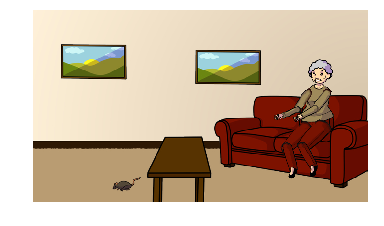

In [12]:
img = plt.imread(f"data/train/images/{data['file_name'].replace('png', 'jpg')}")
plt.imshow(img)
plt.axis('off');

In [16]:
scene = data['scene']
print(scene['sceneType'])

objects = scene['availableObject'] # list

Living-XinleiSubset


In [17]:
from collections import namedtuple
Obj = namedtuple('Obj', ['name', 'x', 'y', 'z', 'flip', 'pose_type'])

In [18]:
objs = []
for i in range(len(objects)):
    object_instances = objects[i]['instance']
    for instance in object_instances:
        if instance['present']:
            objs.append(Obj(instance['name'], instance['x'], instance['y'], instance['z'], instance['flip'],
                            instance['typeID'] if 'typeID' in instance else instance['poseID'] if 'poseID' in instance else -1))
objs

[Obj(name='Doll08', x=585, y=205, z=2, flip=0, pose_type=-1),
 Obj(name='Rat', x=196, y=364, z=2, flip=0, pose_type=3),
 Obj(name='CoffeeTable', x=306, y=339, z=2, flip=1, pose_type=1),
 Obj(name='Picture', x=128, y=109, z=2, flip=0, pose_type=2),
 Obj(name='Picture', x=409, y=121, z=2, flip=0, pose_type=2),
 Obj(name='Sofa', x=554, y=275, z=2, flip=0, pose_type=1)]

In [ ]:
objs = []
for i in range(len(obj_instance)):
    objs.extend([obj(o['part'], o['childX'], o['childY']) for o in obj_instance[i]['body']])
objs = list(set(objs))
objs

## Superpixels

In [92]:
imgg = img

Felzenszwalb number of segments: 738
SLIC number of segments: 10
Quickshift number of segments: 1652


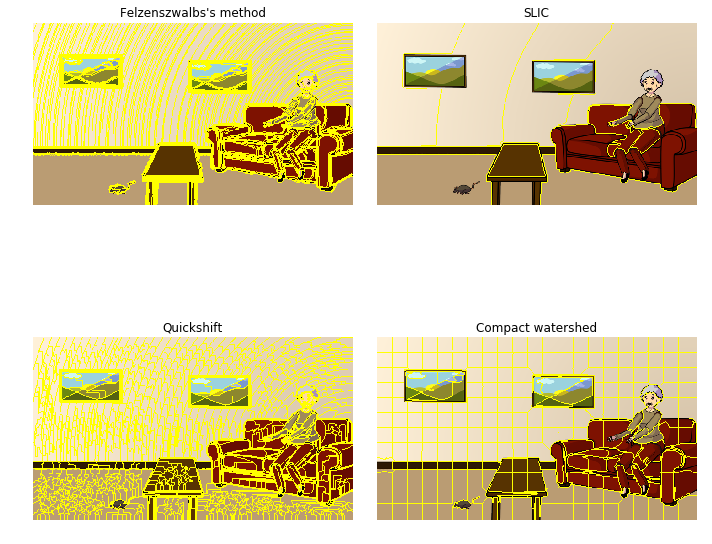

In [95]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = imgg[:, :, :-1]

segments_fz = felzenszwalb(img, scale=100, sigma=0.1, min_size=20)
segments_slic = slic(img, n_segments=20, compactness=1, sigma=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'})

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

# VQATools Demo

In [ ]:
split = 'train'

annotations_path = f'data/{split}/abstract_v002_train2015_annotations.json'
# questions_path = f'data/{split}/OpenEnded_abstract_v002_train2015_questions.json'
questions_path = 'data/train/MultipleChoice_abstract_v002_train2015_questions.json'
img_dir = f'data/{split}/images/'

vqa=VQA(annotations_path, questions_path) # initialize VQA api for QA annotations

Question: What color are the flowers?
Answer 1: yellow
Answer 2: yellow
Answer 3: yellow
Answer 4: yellow
Answer 5: yellow
Answer 6: yellow
Answer 7: yellow
Answer 8: yellow
Answer 9: yellow
Answer 10: yellow


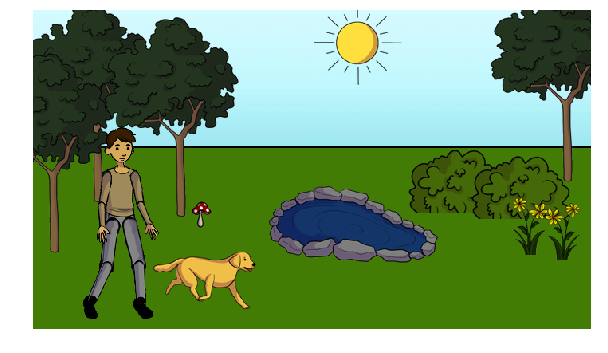

In [3]:
# load and display QA annotations for given question types
annotation_ids = vqa.getQuesIds()
annotations = vqa.loadQA(annotation_ids)
annotation = np.random.choice(annotations)
vqa.showQA([annotation])
img_id = annotation['image_id']

img_fname = f"data/{split}/images/abstract_v002_{split}2015_{str(img_id).zfill(12)}.jpg"

img = plt.imread(img_fname)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off');

* what color is (sometimes trickier like "the background of the photo on the wall")
* what animal is < present near an object>
* people's response to something < scared, ;
    * Need facial expression
* relative location (what is in front of ..., in the ground near ...)
* how many ... are there?
* Where is ... (e.g. right; right front; between bushes)
    * might want to know not only (x,y) of objects but also size of the whole image or dx, dy to the edges
* "Are the paintings all the same size"
    * Is it worth storing area of bounding box for each object?
* "Why is there a chair in the middle of the sofas?" Most common answer was "yes" (4)
* Scene characteristics (daytime; outside)
* Emotions (happy; upset; having fun)
* "Is there any healthy food?"

Question: Do you think the couple could have found a warmer place to get a picture taken?
Answer 1: yes
Answer 2: yes
Answer 3: yes
Answer 4: yes
Answer 5: yes
Answer 6: yes
Answer 7: yes
Answer 8: yes
Answer 9: yes
Answer 10: yes


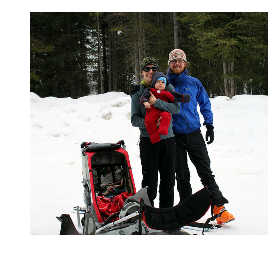

In [26]:
# load and display QA annotations for given answer types
# ansTypes can be one of the following: yes/no, number, other

annIds = vqa.getQuesIds(ansTypes='yes/no')
anns = vqa.loadQA(annIds)
randomAnn = np.random.choice(anns)
vqa.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(img_dir + imgFilename):
    I = plt.imread(img_dir + imgFilename)
    plt.imshow(I)
    plt.axis('off')
    plt.show()

Question: What is the route that this bus is running?
Answer 1: unsure
Answer 2: first route
Answer 3: downtown chicago
Answer 4: straight
Answer 5: city
Answer 6: bus route
Answer 7: london route
Answer 8: hop off
Answer 9: unknown
Answer 10: downtown


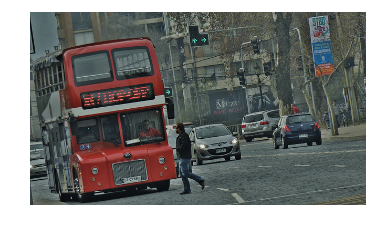

In [38]:
# load and display QA annotations for given images
"""
Usage: vqa.getImgIds(quesIds=[], quesTypes=[], ansTypes=[])
Above method can be used to retrieve imageIds for given question Ids or given question types or given answer types.
"""

ids = vqa.getImgIds()
annIds = vqa.getQuesIds(imgIds=random.sample(ids,5));  
anns = vqa.loadQA(annIds)
randomAnn = np.random.choice(anns)
vqa.showQA([randomAnn])  
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(img_dir + imgFilename):
    I = plt.imread(img_dir + imgFilename)
    plt.imshow(I)
    plt.axis('off')
    plt.show()

In [3]:
q = vqa.getQuesIds()

In [11]:
next(iter(vqa.qqa.keys()))

196608000

In [15]:
v = vqa.qqa.values()

In [16]:
v[0]

[{u'image_id': 196608,
  u'question': u'What is the person touching?',
  u'question_id': 196608000},
 {u'image_id': 265814,
  u'question': u'Is that a car?',
  u'question_id': 265814017},
 {u'image_id': 196608,
  u'question': u'What is on either side of the computer?',
  u'question_id': 196608002},
 {u'image_id': 196608,
  u'question': u'Is the laptop on?',
  u'question_id': 196608003},
 {u'image_id': 420479,
  u'question': u'Where would somebody walk?',
  u'question_id': 420479000},
 {u'image_id': 420479,
  u'question': u'Is this a harbor?',
  u'question_id': 420479001},
 {u'image_id': 420479,
  u'question': u'Are the boats sailing?',
  u'question_id': 420479002},
 {u'image_id': 158335,
  u'question': u'Are the donuts fresh?',
  u'question_id': 158335003},
 {u'image_id': 158335,
  u'question': u'How many sprinkles are on this donut?',
  u'question_id': 158335004},
 {u'image_id': 122527,
  u'question': u"What superhero is on the boy's hat?",
  u'question_id': 122527000},
 {u'image_id':

# Demo Model
**Loading**
* How to efficiently load the images during training for TF?

**Preprocessing**
* Convert images to float32 instead of uint8
* Try to do some dynamic pooling (e.g SPP or...) so that we don't have to resize
    * Does `tf.nn.fractional_.._pool` help at all?
* Add random left-right flips
* Add random crops? Hard to say if you get rid of something important...
* Embed the words of the question using, e.g., Glove

**Pre-trained Models**
* Consider finding some RNN trained to do question answering already?
* Consider other word vectors?

**Models**
* Compare concatenating the image and question embeddings vs multiplying them

**Training**
* Finetune the CNN or no?

In [168]:
with open('data/answer_to_id.pkl', 'rb') as f:
    answer_to_id = pickle.load(f)

with open('data/word_to_id.pkl', 'rb') as f:
    word_to_id = pickle.load(f)

train_qa = pd.read_hdf('data/train/qa.h5')
val_qa = pd.read_hdf('data/val/qa.h5')

train_qa.head()

,answer,choices,img_path,question
0,man,"[alive, 1, woman, purple, 2, yes, white, boy, ...",data/train/images/abstract_v002_train2015_0000...,who looks happier
1,blanket,"[3, no, blue, red, 1, slide, monkey bars, jump...",data/train/images/abstract_v002_train2015_0000...,where is the woman sitting
2,bench,"[away, yes, blue, 1, 2, mouse, couch, no, yell...",data/train/images/abstract_v002_train2015_0000...,where is the man sitting
3,yes,"[water, yellow, 4, running, blue, pouring, out...",data/train/images/abstract_v002_train2015_0000...,is this man hungry
4,soda,"[wine, girl would fall, soda, white, yes, coke...",data/train/images/abstract_v002_train2015_0000...,what kind of drink is that


In [169]:
def question_to_ids(question: str, pad_to_length: int):
    unk_val = word_to_id['<UNK>']
    pad_val = word_to_id['<PAD>']
    assert pad_val == 0

    ids = [word_to_id.get(word, unk_val) for word in question.split(' ')]
    return ids + [pad_val] * (pad_to_length - len(ids))

In [171]:
# convert words and answers to ids
max_question_length = train_qa.question.map(lambda question: len(question.split(' '))).max()

train_questions = np.array(train_qa.question.map(lambda question: question_to_ids(question, max_question_length)).tolist())
val_questions = np.array(val_qa.question.map(lambda question: question_to_ids(question, max_question_length)).tolist())

unk_val = answer_to_id['<UNK>']
train_answers = train_qa.answer.map(lambda answer: answer_to_id.get(answer, unk_val)).values
val_answers = val_qa.answer.map(lambda answer: answer_to_id.get(answer, unk_val)).values

train_img_paths = train_qa.img_path.values
val_img_paths = val_qa.img_path.values

In [75]:
batch_size = 128
embedding_size = 300
img_size = (500, 500)
n_lstm_units = 512

# csv.QUOTE_NONE = 3; this makes it so things like " are parsed as words instead of as the start of a string
embeddings = pd.read_csv('data/glove.6B.{}d.txt'.format(embedding_size), sep=' ', index_col=0, header=None, quoting=3)
padding = '@PADDING@'
embeddings = pd.concat([embeddings, pd.DataFrame([[0] * embedding_size], index=[padding], columns=embeddings.columns)])

question_ids = vqa.getQuesIds()
questions = [preprocess_question(vqa.qqa[question_id]['question']).split(' ') for question_id in question_ids]

# pad all questions to same length
max_question_length = max(len(question) for question in questions)
questions = np.array([question + [padding] * (max_question_length - len(question)) for question in questions])

In [76]:
tf.reset_default_graph()

In [77]:
images = tf.placeholder(tf.float32, shape=(None, None, None, 3), name='raw_images') # batch x height x width x channels
images = tf.image.resize_images(images, size=img_size)

cnn = tf.contrib.keras.applications.ResNet50(include_top=False, input_tensor=images)
img_embedding = tf.reshape(cnn.output, shape=(-1, np.product(cnn.output.shape.as_list()[1:])))
img_embedding

<tf.Tensor 'Reshape:0' shape=(?, 8192) dtype=float32>

In [78]:
questions_p = tf.placeholder(tf.float32, shape=(None, max_question_length, embedding_size), name='embedded_questions')

rnn_cells = tf.contrib.rnn.LSTMCell(n_lstm_units)
outputs, state = tf.nn.dynamic_rnn(rnn_cells, questions_p, dtype=tf.float32, parallel_iterations=batch_size)

# TODO: fix this to actually get the last relevant output; use state too or only output?
last_output = outputs[:, -1, :]
last_output

<tf.Tensor 'strided_slice:0' shape=(?, 512) dtype=float32>

In [80]:
img_and_question = tf.concat([img_embedding, last_output], axis=1)
img_and_question

<tf.Tensor 'concat_1:0' shape=(?, 8704) dtype=float32>

In [81]:
n_classes = 1000
hidden = tf.layers.dense(img_and_question, 1024, activation=tf.nn.relu)
output = tf.layers.dense(hidden, n_classes)

In [ ]:
tf.contrib.keras.applications.VGG16()

In [ ]:
batch_questions = questions[:batch_size]
embedded_questions = embeddings.loc[batch_questions.ravel()].values.reshape(-1, max_question_length, embedding_size)